<a href="https://colab.research.google.com/github/panomsk/colab/blob/main/DeepSchool_Lightning_%26_CML_hw_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №1

В этом ноутбуке вы найдёте код, реализующий цикл обучения модели. В этом коде достаточно много проблем и неудобств. В рамках домашнего задания нужно улучшить этот код следующим образом:

1. Перепишите трейн луп на Lightning, код должен быть оформлен в виде скриптов на python

1. Параметры обучения должны задаваться в конфиге (проще всего будет использовать библиотеку `omegaconf`)

1. Используйте метод датамодуля `setup` и библиотеку `requests`, чтобы скрипт скачивал датасет. Датасет должен кешироваться, т.е. при повторном запуске скрипта на той же машине мы не должны ждать, пока датасет скачается заново

1. Зафиксируйте зависимости в `requirements.txt`, чтобы окружение легко воспроизводилось

1. Добавьте в Makefile команды для установки зависимостей и запуска тренировки


Необязательные задания со звёздочкой
1. (*) По коду в разных местах раскиданы не лучшие DL-практики (и практики написания кода). Напишите что вам удалось найти в комментарии к заданию. Задание с двумя звёздочками для перфекционистов — исправить то, что нашли:)

1. (*) Добавьте ClearML в проект

1. (*) Прогоните код через форматтеры (`isort`, `black`) и линтеры (e.g. `flake8`), чтобы вам было легче с ним работать

### Примечания
* Если под рукой нет GPU используйте флаг `overfit_batches` для быстрой отладки кода, про него можно прочитать [здесь](https://lightning.ai/docs/pytorch/stable/common/trainer.html#overfit-batches)
* Не стесняйтесь менять исходный код из этого ноутбука до неузнаваемости, руководствуйтесь своим чувством прекрасного и делайте так, чтобы вам самим нравилось
* В этом задании мы не гонимся за метриками, не коптим по 1000 эпох, а оттачиваем инструменты. Лосс падает на первых нескольких эпохах — и славно:) Если вам долго ждать конца обучения, то можете уменьшить количество эпох или размер датасета

### Как сдавать задание
На платформе DeepShool в комментарии к лекции необходимо прикрепить:
1. Архив с кодом (убедитесь что там нет `venv`'a, датасета или ещё чего-то лишнего)
1. Скриншот из tensorboard (`tensorboard --logdir lightning_logs`) или ClearML, на котором видно график с лоссом (и другие графики / визуализации если есть)

# Импорт библиотек

In [ ]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

import torch
import seaborn as sns
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchvision import models, transforms, datasets

# Скачивание датасета

In [ ]:
!rm -rf dataset.zip Classification_data || true
!wget "https://www.dropbox.com/scl/fi/nrn0y41dsfwqsrssav2eo/Classification_data.zip?rlkey=oieytodt749yzyippc6384tge&dl=1" -O dataset.zip
!unzip -q dataset.zip -d .

--2024-11-13 20:38:18--  https://www.dropbox.com/scl/fi/nrn0y41dsfwqsrssav2eo/Classification_data.zip?rlkey=oieytodt749yzyippc6384tge&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb92d075488028bb6fe6f4954c.dl.dropboxusercontent.com/cd/0/inline/CeUPAxkg4VOAMem8nDCgpt-lCt0aD40PMSksGjP60TMU-dzVkLD6DmHbgiCZiK6Cq6OfSY99y9SqAJ-Uh-eMillKK_5MtTIlLOmrb-gxUoXjmn7ITWY3mCZ8xaOE52hTG7V197yDzgWGEdIY8QxKlqGS/file# [following]
--2024-11-13 20:38:19--  https://uccb92d075488028bb6fe6f4954c.dl.dropboxusercontent.com/cd/0/inline/CeUPAxkg4VOAMem8nDCgpt-lCt0aD40PMSksGjP60TMU-dzVkLD6DmHbgiCZiK6Cq6OfSY99y9SqAJ-Uh-eMillKK_5MtTIlLOmrb-gxUoXjmn7ITWY3mCZ8xaOE52hTG7V197yDzgWGEdIY8QxKlqGS/file
Resolving uccb92d075488028bb6fe6f4954c.dl.dropboxusercontent.com (uccb92d075488028bb6fe6f4954c.dl.dropboxusercontent.com)... 1

# Подготовка даталоадеров

In [ ]:
batch_size=256

train_transform = transforms.Compose([
                                transforms.Resize(64),
                                # transforms.RandomResizedCrop(64),
                                transforms.CenterCrop(64),
                                transforms.RandomHorizontalFlip(),
                                transforms.ColorJitter(),
                                transforms.ToTensor()])

test_transform = transforms.Compose([
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor()])

train_dataset = datasets.ImageFolder("/content/Classification_data/train",
                               transform=train_transform)

train_set, val_set = torch.utils.data.random_split(train_dataset, [11228, 2806])

train_dataloader = torch.utils.data.DataLoader(train_set,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_set,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         drop_last=True)

test_dataset = datasets.ImageFolder("/content/Classification_data/test",
                               transform=test_transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              drop_last=True)

# Визуализация данных

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i][0], cmap='gray')
        plt.xlabel(class_names[labels[i]])
    plt.show()

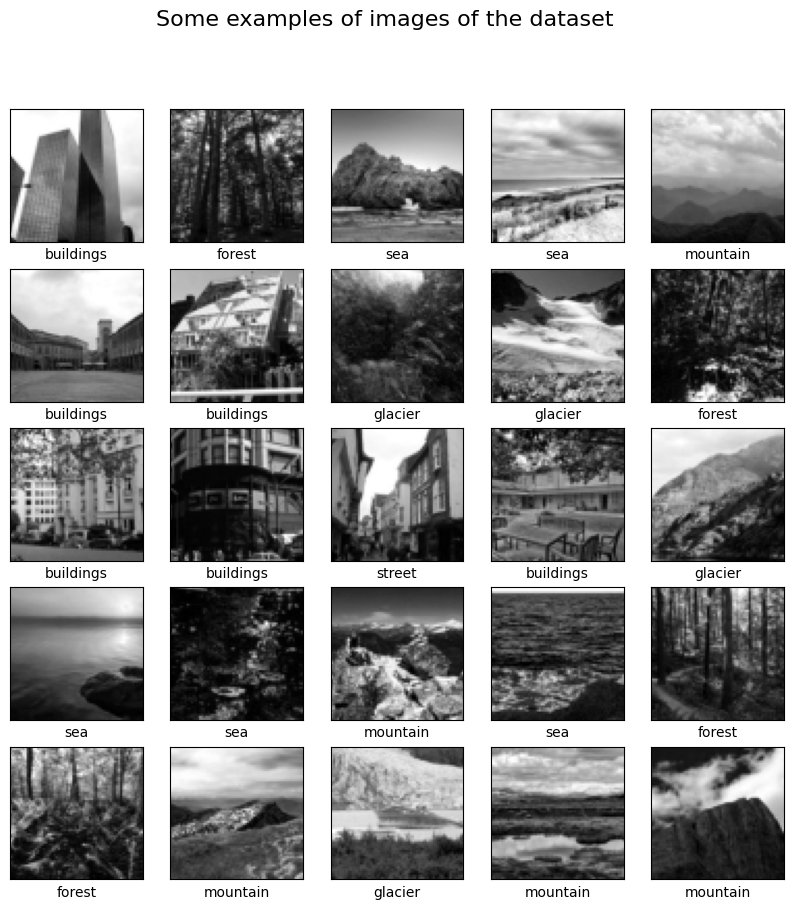

In [ ]:
classes = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')
images, labels = next(iter(train_dataloader))
display_examples(classes, images, labels)

# Архитектура сети

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1)

    self.pool = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(in_features=512 * 4 * 4, out_features=128)
    self.fc2 = nn.Linear(in_features=128, out_features=6)

    self.dropout = nn.Dropout(0.5)
    self.norm = nn.BatchNorm1d(128)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))

    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.norm(x)
    x = self.fc2(x)
    return x

# Обучение модели

In [ ]:
from tqdm import tqdm


DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'


def fit(epochs, model, criterion, optimizer, schedulers, loss_stats, dataloader=train_dataloader, val_loader=val_dataloader):
  print(f'Fitting on {DEVICE}')
  model.to(DEVICE)

  for e in range(epochs):
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in tqdm(train_dataloader, desc=f'Training: epoch {e}'):
      X_train_batch = X_train_batch.to(DEVICE)
      y_train_batch = y_train_batch.to(DEVICE)
      optimizer.zero_grad()

      y_train_pred = model(X_train_batch)
      train_loss = criterion(y_train_pred, y_train_batch)
      train_loss.backward()

      optimizer.step()
      train_epoch_loss += train_loss.item()
    for sch in schedulers:
      scheduler.step()

    # VALIDATION
    with torch.no_grad():
      val_epoch_loss = 0
      model.eval()
      for X_val_batch, y_val_batch in tqdm(val_loader, desc=f'Validation: epoch {e}'):
        X_val_batch, y_val_batch = X_val_batch.to(DEVICE), y_val_batch.to(DEVICE)
        y_val_pred = model(X_val_batch)
        val_loss = criterion(y_val_pred, y_val_batch)
        val_epoch_loss += val_loss.item()
    loss_stats['train'].append(train_epoch_loss/len(train_dataloader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))

    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_dataloader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

In [ ]:
loss_stats = {
    'train': [],
    "val": []
}

epochs = 15
model = CNN()
learning_rate = torch.tensor(1e-2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98, verbose=True)
schedulers = [scheduler]

fit(epochs, model, criterion, optimizer, schedulers, loss_stats)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Fitting on cuda:0


Validation: epoch 0: 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


Epoch 000: | Train Loss: 1.68059 | Val Loss: 1.73056


Validation: epoch 1: 100%|██████████| 10/10 [00:03<00:00,  2.73it/s]


Epoch 001: | Train Loss: 1.40708 | Val Loss: 1.37933


Validation: epoch 2: 100%|██████████| 10/10 [00:03<00:00,  3.27it/s]


Epoch 002: | Train Loss: 1.23698 | Val Loss: 1.24109


Validation: epoch 3: 100%|██████████| 10/10 [00:03<00:00,  3.28it/s]


Epoch 003: | Train Loss: 1.15376 | Val Loss: 1.05401


Validation: epoch 4: 100%|██████████| 10/10 [00:03<00:00,  3.24it/s]


Epoch 004: | Train Loss: 1.06042 | Val Loss: 1.24464


Validation: epoch 5: 100%|██████████| 10/10 [00:03<00:00,  3.30it/s]


Epoch 005: | Train Loss: 1.03426 | Val Loss: 0.95937


Validation: epoch 6: 100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


Epoch 006: | Train Loss: 0.97323 | Val Loss: 1.01470


Validation: epoch 7: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


Epoch 007: | Train Loss: 0.94592 | Val Loss: 1.03222


Validation: epoch 8: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Epoch 008: | Train Loss: 0.91193 | Val Loss: 0.95459


Validation: epoch 9: 100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


Epoch 009: | Train Loss: 0.88368 | Val Loss: 0.85464


Validation: epoch 10: 100%|██████████| 10/10 [00:03<00:00,  2.97it/s]


Epoch 010: | Train Loss: 0.86113 | Val Loss: 1.03441


Validation: epoch 11: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


Epoch 011: | Train Loss: 0.84182 | Val Loss: 0.82254


Validation: epoch 12: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Epoch 012: | Train Loss: 0.81140 | Val Loss: 0.83167


Validation: epoch 13: 100%|██████████| 10/10 [00:03<00:00,  2.78it/s]


Epoch 013: | Train Loss: 0.79966 | Val Loss: 0.83572


Validation: epoch 14: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]

Epoch 014: | Train Loss: 0.77710 | Val Loss: 0.73845


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

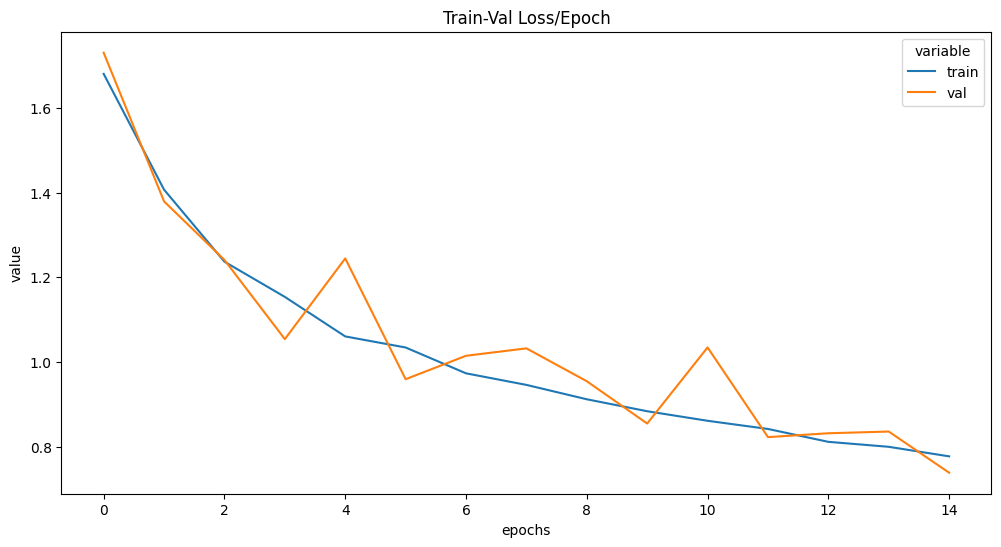

In [ ]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(12,6))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

# Предсказания модели


In [ ]:
def predict(model, batch_size=32, dataloader=test_dataloader, device='cpu'):
  model.to(device)
  classes = ('buildings', 'forest', 'glacier', 'mountain',
           'sea', 'street')
  with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(6)]
    n_class_samples = [0 for i in range(6)]
    for images, labels in tqdm(test_dataloader):
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      n_samples += labels.size(0)
      n_correct += (predicted == labels).sum().item()

      for i in range(batch_size):
        label = labels[i]
        pred = predicted[i]
        if (label == pred):
          n_class_correct[label] += 1
        n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(6):
      acc = 100.0 * n_class_correct[i] / n_class_samples[i]
      print(f'Accuracy of {classes[i]}: {acc} %')

In [ ]:
predict(model)

100%|██████████| 11/11 [00:35<00:00,  3.24s/it]

Accuracy of the network: 73.68607954545455 %
Accuracy of buildings: 65.625 %
Accuracy of forest: 89.0625 %
Accuracy of glacier: 81.25 %
Accuracy of mountain: 62.5 %
Accuracy of sea: 53.125 %
Accuracy of street: 81.25 %
